In [65]:
#this file will do the sysmatic analysis and comparison of xgboost, random forest and neural network by hyperparameter tuning, feature importance, cross validated shap
#cross validated roc, cumulative AUC with respect to features

In [66]:
#read the un-normalzied merged data from the desktop 
import os
os.getcwd()

'c:\\Users\\Zi Li\\Desktop\\capstone project'

In [67]:
import pandas as pd
data = pd.read_csv("merge.csv")

#recategorize diagnosis variable for binary classification later 
data['pheno.diagnosis'] = data['pheno.diagnosis'].map({
    'clinically normal': 0, # Normal mapped to 0
    'clinical abnormal': 1   # Abnormal mapped to 1
})
data = data[[col for col in data.columns if col != 'pheno.diagnosis'] + ['pheno.diagnosis']]    #move target variable to the last column

#Display the first 5 rows of the data set to make sure it was read in properly
data.head()

,baseline_score.stroop,baseline_score.flanker,baseline_score.card,baseline_score.gonogo,baseline_score.episodic_memory,baseline_score.nback,press_count_dom_ind_avg,pheno.diagnosis
0,7.271971,6.893307,40,158,3.625000,2.214441,107.666667,0
1,6.876421,7.150944,29,150,3.133333,0.935307,101.333333,0
2,8.071578,7.515032,36,152,4.076923,2.367725,124.666667,0
3,7.333112,7.216924,34,158,3.357143,0.216219,95.333333,0
4,8.040952,6.915358,39,74,4.230769,3.210404,107.000000,0


In [68]:
# Data Normalization

In [69]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import skew, kurtosis, shapiro

#Features and target
X = data.drop('pheno.diagnosis', axis=1)
y = data['pheno.diagnosis']


X2 = data.drop('pheno.diagnosis', axis=1)   #saved for feature importance later, keep the original feature name
y2 = data['pheno.diagnosis']
#Split: 75% training, 25% testing before normalization, reduce data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

#Before normalization
means_before = X_train.mean()
stds_before = X_train.std()

#Create table
summary_table1 = pd.DataFrame({
    'Feature': X.columns,
    'Mean (Before)': means_before.round(4),
    'Std Dev (Before)': stds_before.round(4)
})

print(summary_table1)

                                                       Feature  Mean (Before)  \
baseline_score.stroop                    baseline_score.stroop         7.0853   
baseline_score.flanker                  baseline_score.flanker         7.0138   
baseline_score.card                        baseline_score.card        36.0465   
baseline_score.gonogo                    baseline_score.gonogo       134.0465   
baseline_score.episodic_memory  baseline_score.episodic_memory         3.2532   
baseline_score.nback                      baseline_score.nback         1.8937   
press_count_dom_ind_avg                press_count_dom_ind_avg       116.4128   

                                Std Dev (Before)  
baseline_score.stroop                     0.7405  
baseline_score.flanker                    0.3721  
baseline_score.card                       3.0625  
baseline_score.gonogo                    34.4611  
baseline_score.episodic_memory            0.7072  
baseline_score.nback                      1.0

In [70]:
#normalize the training and testing set and compare with them before normalization
#Initialize StandardScaler
scaler = StandardScaler()

#Fit scaler on training data only
X_train = scaler.fit_transform(X_train)

#Transform test data using training parameters
X_test = scaler.transform(X_test)

#after normalization
means_after = X_train.mean()
stds_after = X_train.std()

#Create table
summary_table2 = pd.DataFrame({
    'Feature': X.columns,
    'Mean (after)': means_after.round(4),
    'Std Dev (after)': stds_after.round(4)
})

print(summary_table2)


                          Feature  Mean (after)  Std Dev (after)
0           baseline_score.stroop           0.0              1.0
1          baseline_score.flanker           0.0              1.0
2             baseline_score.card           0.0              1.0
3           baseline_score.gonogo           0.0              1.0
4  baseline_score.episodic_memory           0.0              1.0
5            baseline_score.nback           0.0              1.0
6         press_count_dom_ind_avg           0.0              1.0


In [71]:
# Hyperparameter Tuning

In [72]:
#hyperparameter tuning for xgboost first

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#Assuming y_train and y_test are already binary (0 for normal, 1 for abnormal)
y_train_binary = y_train.values
y_test_binary = y_test.values

pos_count = sum(y_train_binary)
neg_count = len(y_train_binary) - pos_count
scale_pos_weight = neg_count / pos_count

#Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight = scale_pos_weight

)

#Define parameter grid
param_grid = {
    'n_estimators': [50, 75, 100, 125, 150, 200],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.001, 0.005, 0.01,0.05,0.1,0.15,0.2]
}

#Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='recall',        # Optimize for recall
    n_jobs=-1            # Use all cores
)

#Run grid search
grid_search.fit(X_train, y_train_binary)

#Retrieve and print best parameters and best score
best_params = grid_search.best_params_
best_score = round(grid_search.best_score_, 4)

print("Best Parameters Found:")
for param_name, param_value in best_params.items():
    print(f"  {param_name}: {param_value}")

print(f"\nBest Cross-Validated F1 Score: {best_score}")


Best Parameters Found:
  learning_rate: 0.005
  max_depth: 2
  n_estimators: 125

Best Cross-Validated F1 Score: 0.7


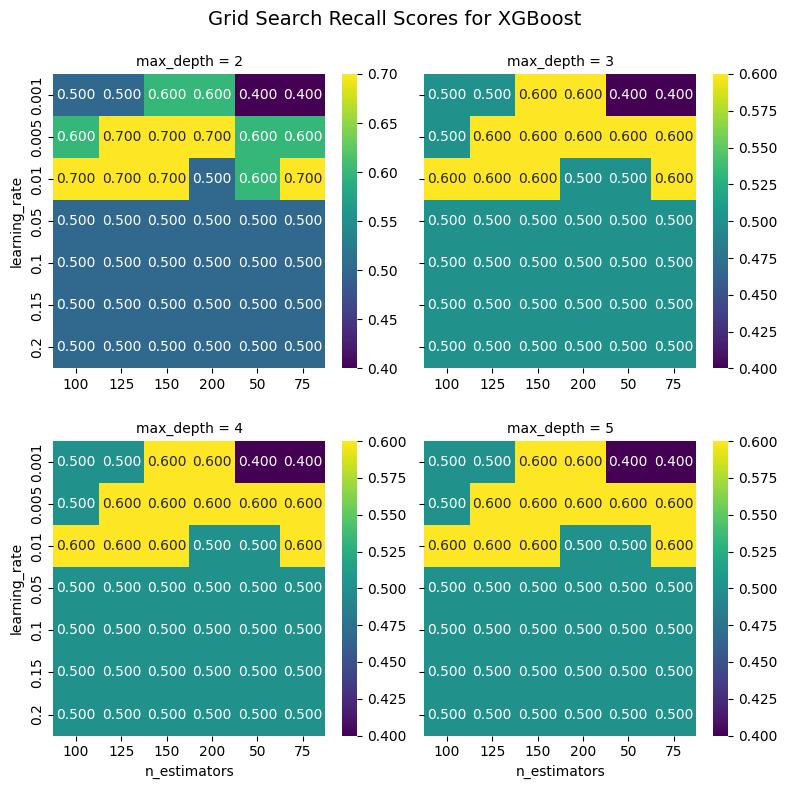

{'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 125}
0.7


In [73]:
#visualize hyperparameter tuning for xgboost 

import seaborn as sns
import matplotlib.pyplot as plt

results_df = pd.DataFrame(grid_search.cv_results_)

results_df['param_learning_rate'] = results_df['param_learning_rate'].astype(float).round(5)
results_df['param_n_estimators'] = results_df['param_n_estimators'].astype(str)  # <-- convert to string
results_df['param_max_depth'] = results_df['param_max_depth'].astype(int)

#Draw heatmaps faceted by max_depth
g = sns.FacetGrid(
    results_df,
    col='param_max_depth',
    col_wrap=2,
    height=4,
    sharex=False,
    sharey=True
)

g.map_dataframe(
    lambda data, color: sns.heatmap(
        data.pivot(index="param_learning_rate", columns="param_n_estimators", values="mean_test_score"),
        annot=True, fmt=".3f", cmap="viridis", cbar=True
    )
)

g.set_titles("max_depth = {col_name}")
g.set_axis_labels("n_estimators", "learning_rate")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Grid Search Recall Scores for XGBoost", fontsize=14)
plt.show()

print(grid_search.best_params_)
print(grid_search.best_score_)

In [74]:
#test it on the test set using the optimal parameters, xgboost

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report

#Use best model from grid search
best_xgb_model = grid_search.best_estimator_

#Predict on test set
y_pred_test = best_xgb_model.predict(X_test)

#Evaluate
test_accuracy = accuracy_score(y_test_binary, y_pred_test)
test_recall = recall_score(y_test_binary, y_pred_test)
conf_matrix_xgboost = confusion_matrix(y_test_binary, y_pred_test)
class_report = classification_report(y_test_binary, y_pred_test)

#Print evaluation results
print(f"Test Set Accuracy: {round(test_accuracy, 4)}")
print(f"Test Set Recall (Focus Metric): {round(test_recall, 4)}")

print("Final XGBoost Model Parameters Used:")
print(f"  learning_rate: {best_xgb_model.get_params()['learning_rate']}")
print(f"  max_depth: {best_xgb_model.get_params()['max_depth']}")
print(f"  n_estimators: {best_xgb_model.get_params()['n_estimators']}")







Test Set Accuracy: 0.7333
Test Set Recall (Focus Metric): 0.6667
Final XGBoost Model Parameters Used:
  learning_rate: 0.005
  max_depth: 2
  n_estimators: 125


In [75]:
#get confusion matrix properties of xgboost using best parameters in the test set

import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

#Extract counts from confusion matrix
TN, FP, FN, TP = conf_matrix_xgboost.ravel()
total = TP + TN + FP + FN

#Compute metrics
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP) if (TN + FP) != 0 else float('nan')
ppv = TP / (TP + FP)
npv = TN / (TN + FN) if (TN + FN) != 0 else float('nan')
precision = precision_score(y_test_binary, y_pred_test)
recall = recall_score(y_test_binary, y_pred_test)
f1 = f1_score(y_test_binary, y_pred_test)
prevalence = (TP + FN) / total
detection_rate = TP / total
detection_prevalence = (TP + FP) / total
accuracy = (TP + TN) / total

#Compile into table
metrics_table = pd.DataFrame({
    'Metric': [
        'Sensitivity (Recall)',
        'Specificity',
        'Positive Predictive Value (PPV)',
        'Negative Predictive Value (NPV)',
        'Precision',
        'Recall',
        'F1 Score',
        'Prevalence',
        'Detection Rate',
        'Detection Prevalence',
        'Accuracy'
    ],
    'Value': [
        round(sensitivity, 4),
        round(specificity, 4),
        round(ppv, 4),
        round(npv, 4),
        round(precision, 4),
        round(recall, 4),
        round(f1, 4),
        round(prevalence, 4),
        round(detection_rate, 4),
        round(detection_prevalence, 4),
        round(accuracy, 4)
    ]
})

#Display table
print(metrics_table)


                             Metric   Value
0              Sensitivity (Recall)  0.6667
1                       Specificity  0.7500
2   Positive Predictive Value (PPV)  0.4000
3   Negative Predictive Value (NPV)  0.9000
4                         Precision  0.4000
5                            Recall  0.6667
6                          F1 Score  0.5000
7                        Prevalence  0.2000
8                    Detection Rate  0.1333
9              Detection Prevalence  0.3333
10                         Accuracy  0.7333


In [76]:
#hyperparameter tuning for random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42)

#Define parameter grid (only n_estimators and max_depth)
param_grid = {
    'n_estimators': [50, 75,100,125,150,175, 200,225, 250],
    'max_depth': [None, 5, 6,7,8,9,10]

}

#Set up GridSearchCV (optimize for recall)
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='recall',  
    n_jobs=-1
)

#Run grid search
grid_search_rf.fit(X_train, y_train_binary)

#Retrieve and print best parameters and score
best_params_rf = grid_search_rf.best_params_
best_score_rf = round(grid_search_rf.best_score_, 4)

print("Best Parameters Found (Random Forest):")
for param_name, param_value in best_params_rf.items():
    print(f"  {param_name}: {param_value}")

print(f"\nBest Cross-Validated Recall: {best_score_rf}")

Best Parameters Found (Random Forest):
  max_depth: None
  n_estimators: 50

Best Cross-Validated Recall: 0.5


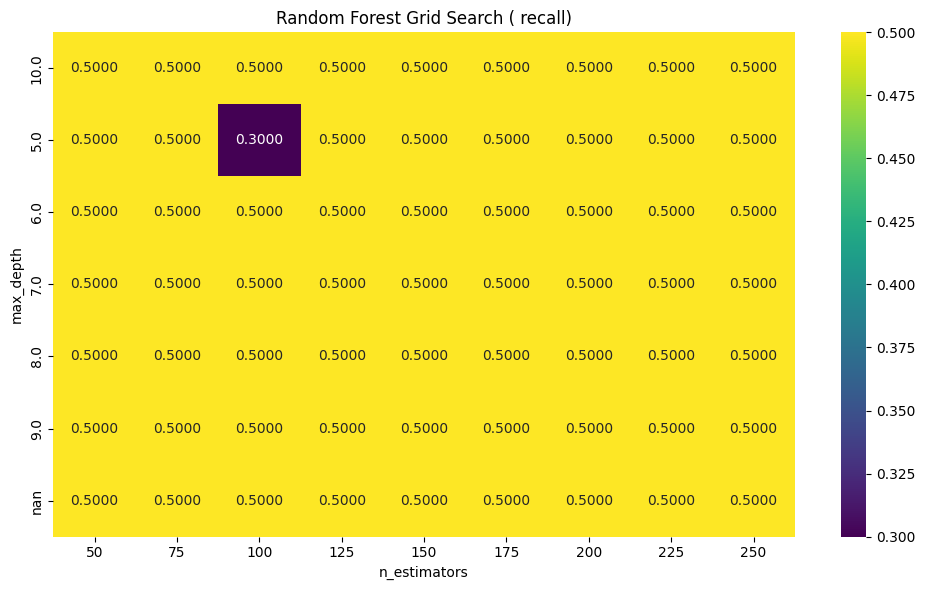

In [77]:
#visualize hyparameter tuing for random forest
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Convert GridSearchCV results to DataFrame
rf_results_df = pd.DataFrame(grid_search_rf.cv_results_)

#Format parameters for plotting
rf_results_df['param_n_estimators'] = rf_results_df['param_n_estimators'].astype(int)
rf_results_df['param_max_depth'] = rf_results_df['param_max_depth'].apply(lambda x: 'None' if x is None else str(x))

#Create pivot table for heatmap
pivot_table = rf_results_df.pivot(
    index='param_max_depth',
    columns='param_n_estimators',
    values='mean_test_score'
)

#Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap='viridis', cbar=True)

plt.title("Random Forest Grid Search ( recall)")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

In [78]:
#use the optimal parameters for random forest for test set
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report

#Use best Random Forest model from GridSearchCV
best_rf_model = grid_search_rf.best_estimator_

#Predict on test set
y_pred_test_rf = best_rf_model.predict(X_test)

#Evaluate
test_accuracy_rf = accuracy_score(y_test_binary, y_pred_test_rf)
test_recall_rf = recall_score(y_test_binary, y_pred_test_rf)
conf_matrix_rf = confusion_matrix(y_test_binary, y_pred_test_rf)
class_report_rf = classification_report(y_test_binary, y_pred_test_rf)

#Print evaluation results
print(f"Test Set Accuracy (Random Forest): {round(test_accuracy_rf, 4)}")
print(f"Test Set Recall (Focus Metric - Sensitivity): {round(test_recall_rf, 4)}")

print("\nConfusion Matrix (Random Forest):")
print(conf_matrix_rf)

print("\nClassification Report (Random Forest):")
print(class_report_rf)

#Print final model parameters used
print("\nFinal Random Forest Model Parameters Used:")
print(f"  max_depth: {best_rf_model.get_params()['max_depth']}")
print(f"  n_estimators: {best_rf_model.get_params()['n_estimators']}")

Test Set Accuracy (Random Forest): 0.8667
Test Set Recall (Focus Metric - Sensitivity): 0.6667

Confusion Matrix (Random Forest):
[[11  1]
 [ 1  2]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.67      0.67      0.67         3

    accuracy                           0.87        15
   macro avg       0.79      0.79      0.79        15
weighted avg       0.87      0.87      0.87        15


Final Random Forest Model Parameters Used:
  max_depth: None
  n_estimators: 50


In [79]:
#get confusion matrix properties of random forest using best parameters in the test set

import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

#Extract counts from Random Forest confusion matrix
TN, FP, FN, TP = conf_matrix_rf.ravel()
total = TP + TN + FP + FN

#Compute metrics
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP) if (TN + FP) != 0 else float('nan')
ppv = TP / (TP + FP)
npv = TN / (TN + FN) if (TN + FN) != 0 else float('nan')
precision = precision_score(y_test_binary, y_pred_test_rf)
recall = recall_score(y_test_binary, y_pred_test_rf)
f1 = f1_score(y_test_binary, y_pred_test_rf)
prevalence = (TP + FN) / total
detection_rate = TP / total
detection_prevalence = (TP + FP) / total
accuracy = (TP + TN) / total

#Compile into table
metrics_table_rf = pd.DataFrame({
    'Metric': [
        'Sensitivity (Recall)',
        'Specificity',
        'Positive Predictive Value (PPV)',
        'Negative Predictive Value (NPV)',
        'Precision',
        'Recall',
        'F1 Score',
        'Prevalence',
        'Detection Rate',
        'Detection Prevalence',
        'Accuracy'
    ],
    'Value': [
        round(sensitivity, 4),
        round(specificity, 4),
        round(ppv, 4),
        round(npv, 4),
        round(precision, 4),
        round(recall, 4),
        round(f1, 4),
        round(prevalence, 4),
        round(detection_rate, 4),
        round(detection_prevalence, 4),
        round(accuracy, 4)
    ]
})

#Display metrics table for Random Forest
print(metrics_table_rf)

#Show final Random Forest model parameters used
print("\nFinal Random Forest Model Parameters Used:")
print(f"  max_depth: {best_rf_model.get_params()['max_depth']}")
print(f"  n_estimators: {best_rf_model.get_params()['n_estimators']}")

                             Metric   Value
0              Sensitivity (Recall)  0.6667
1                       Specificity  0.9167
2   Positive Predictive Value (PPV)  0.6667
3   Negative Predictive Value (NPV)  0.9167
4                         Precision  0.6667
5                            Recall  0.6667
6                          F1 Score  0.6667
7                        Prevalence  0.2000
8                    Detection Rate  0.1333
9              Detection Prevalence  0.2000
10                         Accuracy  0.8667

Final Random Forest Model Parameters Used:
  max_depth: None
  n_estimators: 50


In [80]:
# Feature Importance

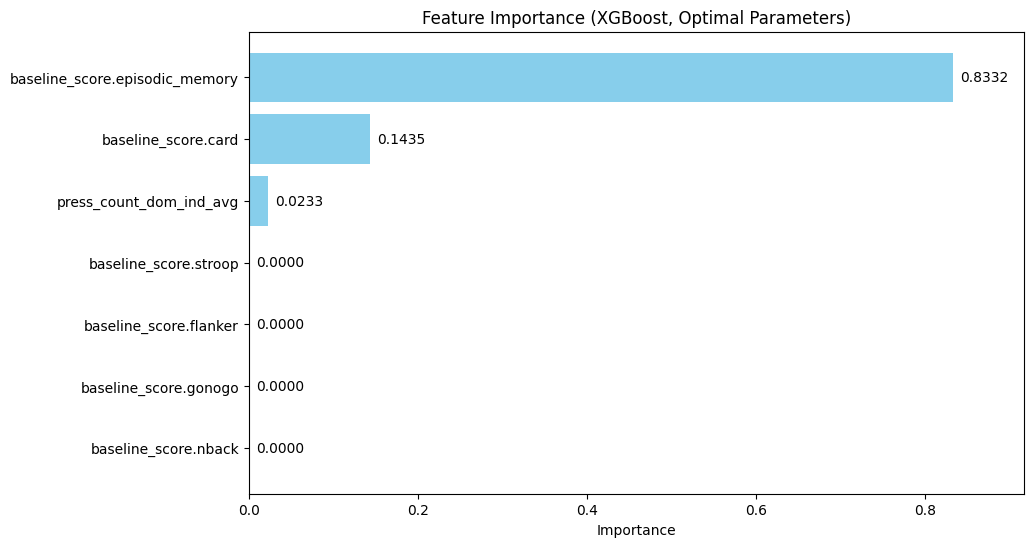

In [81]:
#feature importance for xgboost using the training set using optimal parameters, without shap

import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

#Use original feature names
feature_names = X2.columns

#Train XGBoost with optimal parameters
xgb_final_model = xgb.XGBClassifier(
    learning_rate=0.005,
    max_depth=2,
    n_estimators=125,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

#X_train should be your scaled NumPy array
xgb_final_model.fit(X_train, y_train_binary)

#Compute feature importances
importances_xgb = xgb_final_model.feature_importances_

feature_importance_df_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=False)

#Plot horizontal bars
plt.figure(figsize=(10, 6))
bars = plt.barh(
    feature_importance_df_xgb['Feature'],
    feature_importance_df_xgb['Importance'],
    color='skyblue'
)
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost, Optimal Parameters)')
plt.gca().invert_yaxis()

#Expand x-axis for space
max_importance = feature_importance_df_xgb['Importance'].max()
plt.xlim(0, max_importance * 1.1)

#Add text labels next to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + max_importance * 0.01,
             bar.get_y() + bar.get_height() / 2,
             f'{width:.4f}',
             va='center')

plt.show()


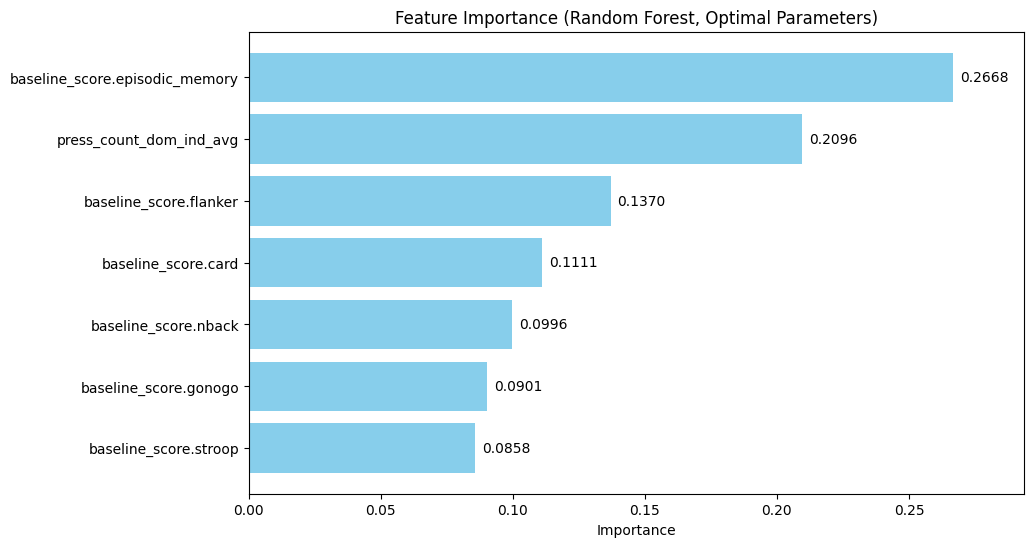

In [82]:
#feature importance for random forest using training se using optimal parameters, without shap

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

#Use original feature names
feature_names = X2.columns

#Train Random Forest with optimal parameters
rf_final_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    random_state=42
)

#Train on scaled data
rf_final_model.fit(X_train, y_train_binary)

#Compute feature importances
importances_rf = rf_final_model.feature_importances_

feature_importance_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

#Plot horizontal bars with importance values shown
plt.figure(figsize=(10, 6))
bars = plt.barh(
    feature_importance_df_rf['Feature'],
    feature_importance_df_rf['Importance'],
    color='skyblue'
)
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest, Optimal Parameters)')
plt.gca().invert_yaxis()

#Expand x-axis slightly for text labels
max_importance = feature_importance_df_rf['Importance'].max()
plt.xlim(0, max_importance * 1.1)

#Add numeric importance values next to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + max_importance * 0.01,
             bar.get_y() + bar.get_height() / 2,
             f'{width:.4f}',
             va='center')

plt.show()


In [83]:
# Cross-Validated SHAP Analysis

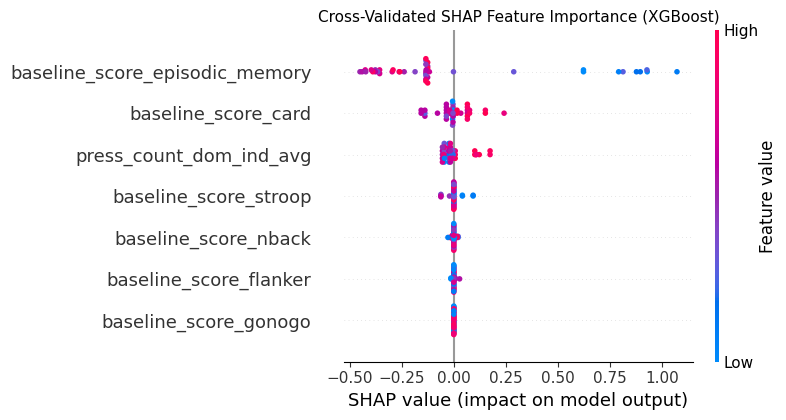

In [84]:
#using 5 fold cross fold validation for shap for xgboost


import numpy as np
import pandas as pd
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

feature_names = [
    'baseline_score_stroop',
    'baseline_score_flanker',
    'baseline_score_card',
    'baseline_score_gonogo',
    'baseline_score_episodic_memory',
    'baseline_score_nback',
    'press_count_dom_ind_avg'
]

#Ensure X_train and y_train are NumPy arrays
X_train_np = X_train if isinstance(X_train, np.ndarray) else X_train.values
y_train_np = np.array(y_train)  # Ensure pure NumPy array

#XGBoost parameters
xgb_params = {
    'learning_rate': 0.005,
    'max_depth': 2,
    'n_estimators': 125,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

#5-fold cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Store SHAP values and corresponding validation features
all_shap_values = []
all_val_features = []

#Cross-validated SHAP computation
for train_idx, val_idx in kf.split(X_train_np, y_train_np):
    X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
    y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]

    #Train XGBoost model
    model = XGBClassifier(**xgb_params)
    model.fit(X_train_fold, y_train_fold)

    #SHAP explainer on validation fold
    explainer = shap.Explainer(model, X_val_fold)
    shap_values = explainer(X_val_fold).values

    #Store SHAP values and validation features
    all_shap_values.append(shap_values)
    all_val_features.append(X_val_fold)

#Stack all SHAP values and validation features
shap_values_full = np.vstack(all_shap_values)
X_val_full = np.vstack(all_val_features)

#Plot SHAP summary plot (cross-validated feature importance)
plt.title('Cross-Validated SHAP Feature Importance (XGBoost)', fontsize=11)

shap.summary_plot(
    shap_values_full,
    X_val_full,
    feature_names=feature_names 
)

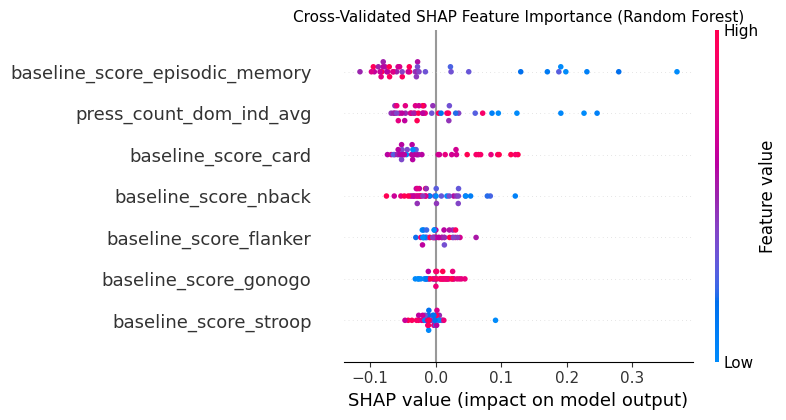

In [85]:
#cross validated shap for random forest 
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

#Feature names
feature_names = [
    'baseline_score_stroop',
    'baseline_score_flanker',
    'baseline_score_card',
    'baseline_score_gonogo',
    'baseline_score_episodic_memory',
    'baseline_score_nback',
    'press_count_dom_ind_avg'
]

#Ensure input formats and integer labels
X_train_np = np.array(X_train)
y_train_np = np.array(y_train).astype(int)

#Random Forest parameters
rf_params = {
    'n_estimators': 50,
    'max_depth': None,
    'random_state': 42
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_shap_values = []
all_val_features = []

#Cross-validated SHAP computation
for train_idx, val_idx in kf.split(X_train_np, y_train_np):
    X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
    y_train_fold = y_train_np[train_idx]

    model = RandomForestClassifier(**rf_params)
    model.fit(X_train_fold, y_train_fold)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val_fold, check_additivity=False)

    #Handle output shape
    if isinstance(shap_values, list):
        shap_values_class1 = shap_values[1]
    else:
        if shap_values.ndim == 3:
            shap_values_class1 = shap_values[:, :, 1]  
        else:
            shap_values_class1 = shap_values 

    all_shap_values.append(shap_values_class1)
    all_val_features.append(X_val_fold)

#Stack SHAP values and features across folds
shap_values_full = np.vstack(all_shap_values)
X_val_full = np.vstack(all_val_features)

#Ensure shapes match
assert shap_values_full.shape == X_val_full.shape, \
    f"SHAP values shape {shap_values_full.shape} does not match features shape {X_val_full.shape}"

#Plot SHAP summary
plt.title('Cross-Validated SHAP Feature Importance (Random Forest)', fontsize=11)
shap.summary_plot(shap_values_full, X_val_full, feature_names=feature_names)


100%|██████████| 8/8 [00:00<00:00, 109.59it/s]


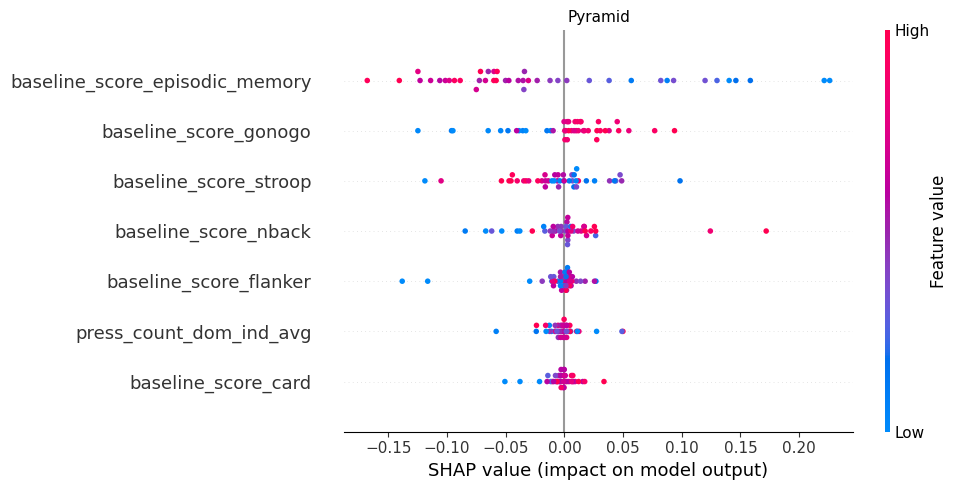

In [86]:
#cross validated shap for neural network, Pyramid 

import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

#Define feature names manually
feature_names = [
    'baseline_score_stroop',
    'baseline_score_flanker',
    'baseline_score_card',
    'baseline_score_gonogo',
    'baseline_score_episodic_memory',
    'baseline_score_nback',
    'press_count_dom_ind_avg'
]

#Prepare data
X_train_np = np.array(X_train)  
y_train_np = np.array(y_train).astype(int)  

#Neural Network parameters
nn_params = {
    'hidden_layer_sizes': (7,5,4,3,2),
    'activation': 'relu',
    'solver': 'adam',
    'max_iter': 1000,
    'random_state': 42
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_shap_values = []
all_val_features = []

#Cross-validated SHAP computation
for train_idx, val_idx in kf.split(X_train_np, y_train_np):
    X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
    y_train_fold = y_train_np[train_idx]  
    y_val_fold = y_train_np[val_idx]     

    #Train neural network
    model = MLPClassifier(**nn_params)
    model.fit(X_train_fold, y_train_fold)

    #Function to predict probability of class 1
    def predict_class1(X):
        return model.predict_proba(X)[:, 1]  

    explainer = shap.KernelExplainer(predict_class1, shap.sample(X_train_fold, 50))
    shap_values = explainer.shap_values(X_val_fold)

    #Store SHAP values and corresponding validation features
    all_shap_values.append(shap_values)
    all_val_features.append(X_val_fold)

#Stack SHAP values and corresponding features
shap_values_full = np.vstack(all_shap_values)
X_val_full = pd.DataFrame(np.vstack(all_val_features), columns=feature_names)

#Plot SHAP Summary Plot
plt.title('Pyramid', fontsize=11)

shap.summary_plot(
    shap_values_full,
    X_val_full,
    plot_size=(10, 5)
)


100%|██████████| 8/8 [00:00<00:00, 106.83it/s]


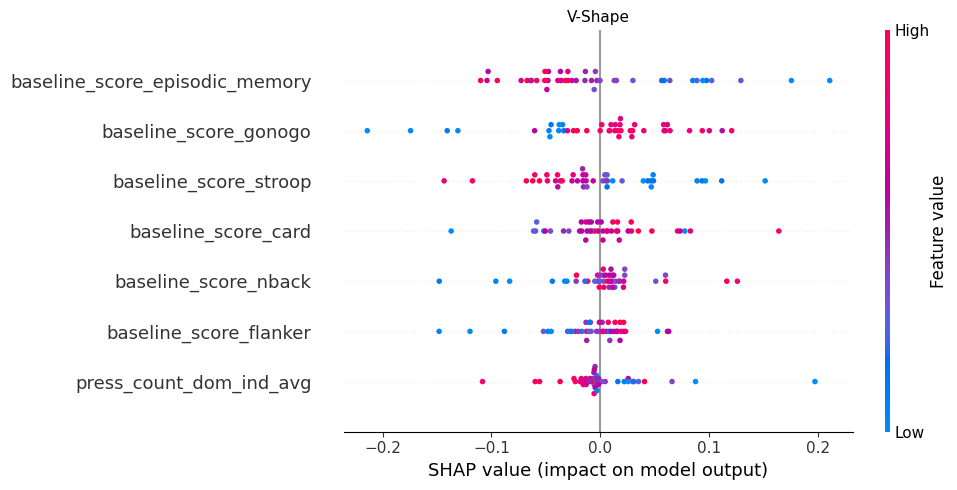

In [87]:
#cross validated shap for neural network, vshape 

import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

#Define feature names manually
feature_names = [
    'baseline_score_stroop',
    'baseline_score_flanker',
    'baseline_score_card',
    'baseline_score_gonogo',
    'baseline_score_episodic_memory',
    'baseline_score_nback',
    'press_count_dom_ind_avg'
]

#Prepare data
X_train_np = np.array(X_train) 
y_train_np = np.array(y_train).astype(int)  

#Neural Network parameters
nn_params = {
    'hidden_layer_sizes': (3,5,6,5,3),
    'activation': 'relu',
    'solver': 'adam',
    'max_iter': 1000,
    'random_state': 42
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_shap_values = []
all_val_features = []

#Cross-validated SHAP computation
for train_idx, val_idx in kf.split(X_train_np, y_train_np):
    X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
    y_train_fold = y_train_np[train_idx]   
    y_val_fold = y_train_np[val_idx]       

    #Train neural network
    model = MLPClassifier(**nn_params)
    model.fit(X_train_fold, y_train_fold)

    #Function to predict probability of class 1
    def predict_class1(X):
        return model.predict_proba(X)[:, 1]  

    #KernelExplainer
    explainer = shap.KernelExplainer(predict_class1, shap.sample(X_train_fold, 50))
    shap_values = explainer.shap_values(X_val_fold)

    #Store SHAP values and corresponding validation features
    all_shap_values.append(shap_values)
    all_val_features.append(X_val_fold)

#Stack SHAP values and corresponding features
shap_values_full = np.vstack(all_shap_values)
X_val_full = pd.DataFrame(np.vstack(all_val_features), columns=feature_names)

#Plot SHAP Summary Plot
plt.title('V-Shape', fontsize=11)

shap.summary_plot(
    shap_values_full,
    X_val_full,
    plot_size=(10, 5)
)


100%|██████████| 8/8 [00:00<00:00, 105.37it/s]


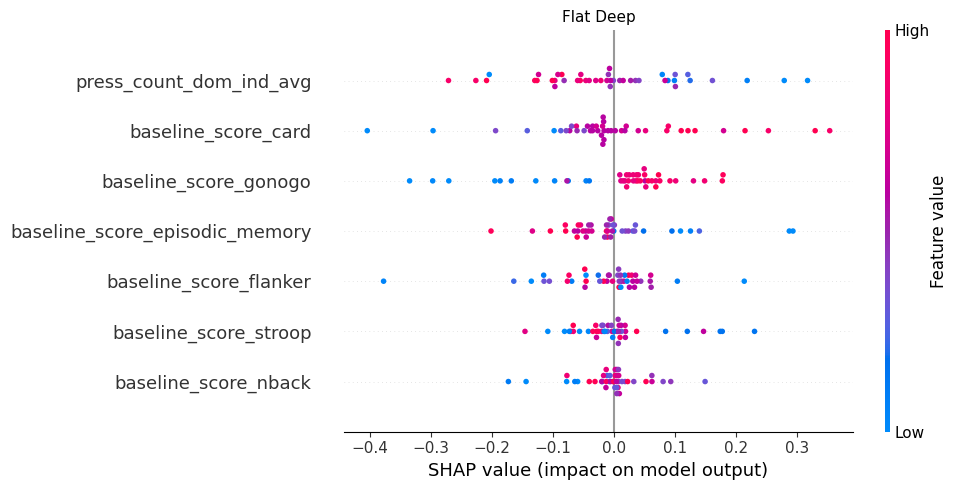

In [88]:
#suggested improvement for cross validation shap for flat deep


import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

#Define feature names manually
feature_names = [
    'baseline_score_stroop',
    'baseline_score_flanker',
    'baseline_score_card',
    'baseline_score_gonogo',
    'baseline_score_episodic_memory',
    'baseline_score_nback',
    'press_count_dom_ind_avg'
]

#Prepare data
X_train_np = np.array(X_train)  
y_train_np = np.array(y_train).astype(int)  

#Neural Network parameters
nn_params = {
    'hidden_layer_sizes': (5,5,5,5,5),
    'activation': 'relu',
    'solver': 'adam',
    'max_iter': 1000,
    'random_state': 42
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_shap_values = []
all_val_features = []

#Cross-validated SHAP computation
for train_idx, val_idx in kf.split(X_train_np, y_train_np):
    X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
    y_train_fold = y_train_np[train_idx]   
    y_val_fold = y_train_np[val_idx]       

    #Train neural network
    model = MLPClassifier(**nn_params)
    model.fit(X_train_fold, y_train_fold)

    #Function to predict probability of class 1
    def predict_class1(X):
        return model.predict_proba(X)[:, 1] 

    #KernelExplainer
    explainer = shap.KernelExplainer(predict_class1, shap.sample(X_train_fold, 50))
    shap_values = explainer.shap_values(X_val_fold)

    #Store SHAP values and corresponding validation features
    all_shap_values.append(shap_values)
    all_val_features.append(X_val_fold)

#Stack SHAP values and corresponding features
shap_values_full = np.vstack(all_shap_values)
X_val_full = pd.DataFrame(np.vstack(all_val_features), columns=feature_names)

#Plot SHAP Summary Plot
plt.title('Flat Deep', fontsize=11)

shap.summary_plot(
    shap_values_full,
    X_val_full,
    plot_size=(10, 5)
)


100%|██████████| 8/8 [00:00<00:00, 106.38it/s]


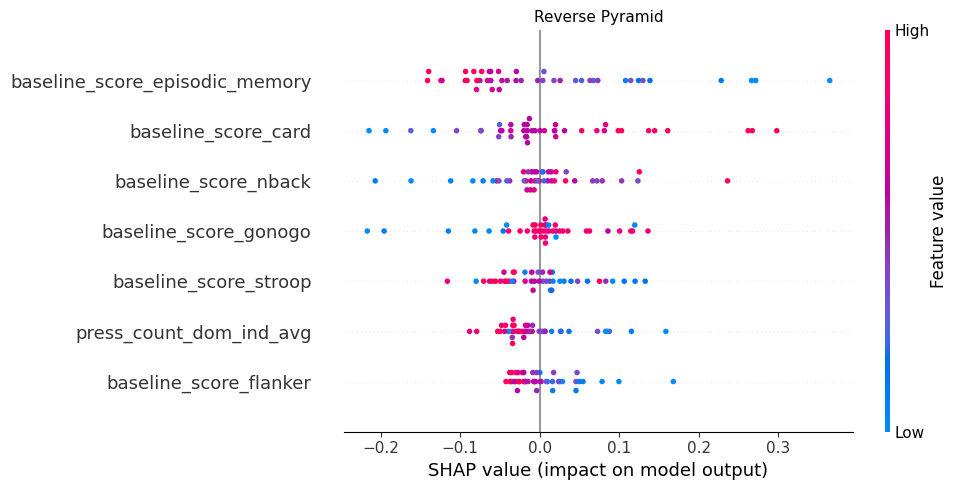

In [89]:
#cross validated shap for neural network, reverse pyrmaid


import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

#Define feature names manually
feature_names = [
    'baseline_score_stroop',
    'baseline_score_flanker',
    'baseline_score_card',
    'baseline_score_gonogo',
    'baseline_score_episodic_memory',
    'baseline_score_nback',
    'press_count_dom_ind_avg'
]

#Prepare data
X_train_np = np.array(X_train)  
y_train_np = np.array(y_train).astype(int)  

#Neural Network parameters
nn_params = {
    'hidden_layer_sizes': (2,3,4,5,6),
    'activation': 'relu',
    'solver': 'adam',
    'max_iter': 1000,
    'random_state': 42
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_shap_values = []
all_val_features = []

#Cross-validated SHAP computation
for train_idx, val_idx in kf.split(X_train_np, y_train_np):
    X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
    y_train_fold = y_train_np[train_idx]  
    y_val_fold = y_train_np[val_idx]       

    #Train neural network
    model = MLPClassifier(**nn_params)
    model.fit(X_train_fold, y_train_fold)

    #Function to predict probability of class 1
    def predict_class1(X):
        return model.predict_proba(X)[:, 1]  

    #KernelExplainer
    explainer = shap.KernelExplainer(predict_class1, shap.sample(X_train_fold, 50))
    shap_values = explainer.shap_values(X_val_fold)

    #Store SHAP values and corresponding validation features
    all_shap_values.append(shap_values)
    all_val_features.append(X_val_fold)

#Stack SHAP values and corresponding features
shap_values_full = np.vstack(all_shap_values)
X_val_full = pd.DataFrame(np.vstack(all_val_features), columns=feature_names)

#Plot SHAP Summary Plot
plt.title('Reverse Pyramid', fontsize=11)

shap.summary_plot(
    shap_values_full,
    X_val_full,
    plot_size=(10, 5)
)


In [90]:
# Cross-Validated ROC

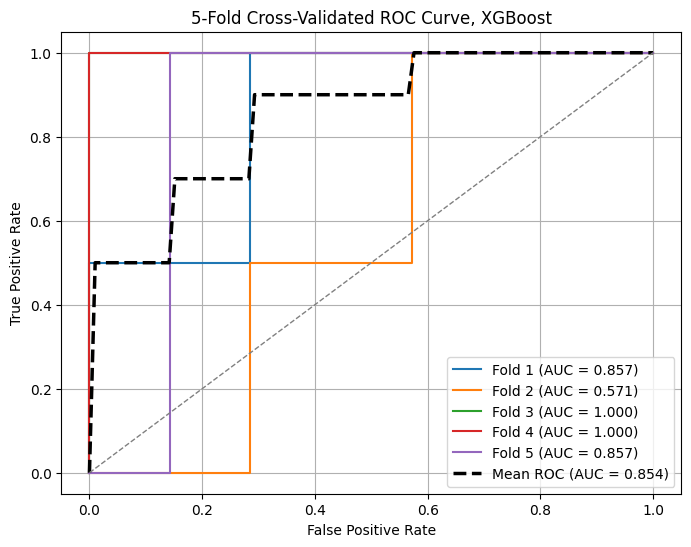

In [91]:
#cross validated roc for xgboost 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

#Ensure X_train and y_train are NumPy arrays
X_train_np = X_train if isinstance(X_train, np.ndarray) else X_train.values
y_train_np = np.array(y_train)  #Ensure pure NumPy array


#XGBoost optimal parameters
xgb_params = {
    'learning_rate': 0.005,
    'max_depth': 2,
    'n_estimators': 125,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
}

#Set up 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Initialize ROC storage
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#Plot setup
plt.figure(figsize=(8, 6))

#Cross-validation loop
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_np, y_train_np)):
    X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
    y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]

    #Train XGBoost on training fold
    model = XGBClassifier(**xgb_params)
    model.fit(X_train_fold, y_train_fold)

    #Predict probabilities on validation fold
    y_proba = model.predict_proba(X_val_fold)[:, 1]

    #Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val_fold, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    #Interpolate TPR to compute mean ROC later
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    #Plot ROC for current fold
    plt.plot(fpr, tpr, lw=1.5, label=f'Fold {i+1} (AUC = {roc_auc:.3f})')

#Plot mean ROC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--',
         label=f'Mean ROC (AUC = {mean_auc:.3f})', lw=2.5)

#Plot chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=1)

#Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5-Fold Cross-Validated ROC Curve, XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

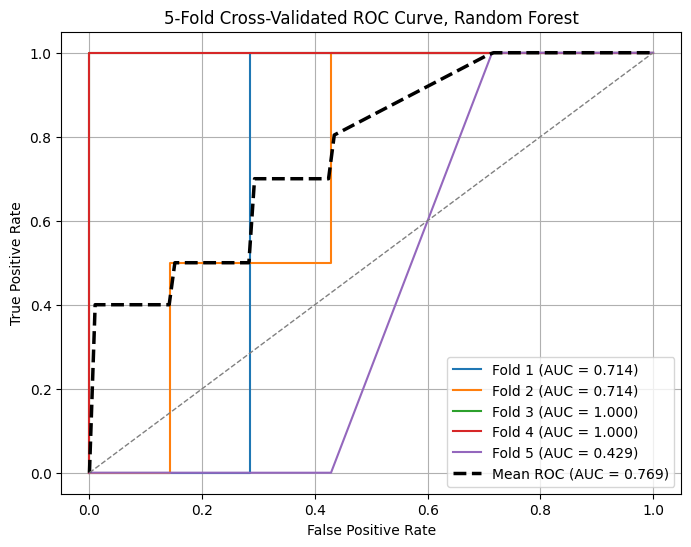

In [92]:
#cross validated roc for random forest for the training set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

#Ensure X_train and y_train are NumPy arrays
X_train_np = X_train if isinstance(X_train, np.ndarray) else X_train.values
y_train_np = np.array(y_train)  #Ensure pure NumPy array

#Random Forest optimized parameters
rf_params = {
    'n_estimators':50,   
    'max_depth': None,    
    'random_state': 42
}

#Set up 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Initialize ROC storage
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#Plot setup
plt.figure(figsize=(8, 6))

#Cross-validation loop
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_np, y_train_np)):
    X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
    y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]

    #Train Random Forest on training fold
    model = RandomForestClassifier(**rf_params)
    model.fit(X_train_fold, y_train_fold)

    #Predict probabilities on validation fold
    y_proba = model.predict_proba(X_val_fold)[:, 1]

    #Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val_fold, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    #Interpolate TPR to compute mean ROC later
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    #Plot ROC for current fold
    plt.plot(fpr, tpr, lw=1.5, label=f'Fold {i+1} (AUC = {roc_auc:.3f})')

#Plot mean ROC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--',
         label=f'Mean ROC (AUC = {mean_auc:.3f})', lw=2.5)

#Plot chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=1)

#Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5-Fold Cross-Validated ROC Curve, Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [93]:
# Cumulative AUC with respect to features 

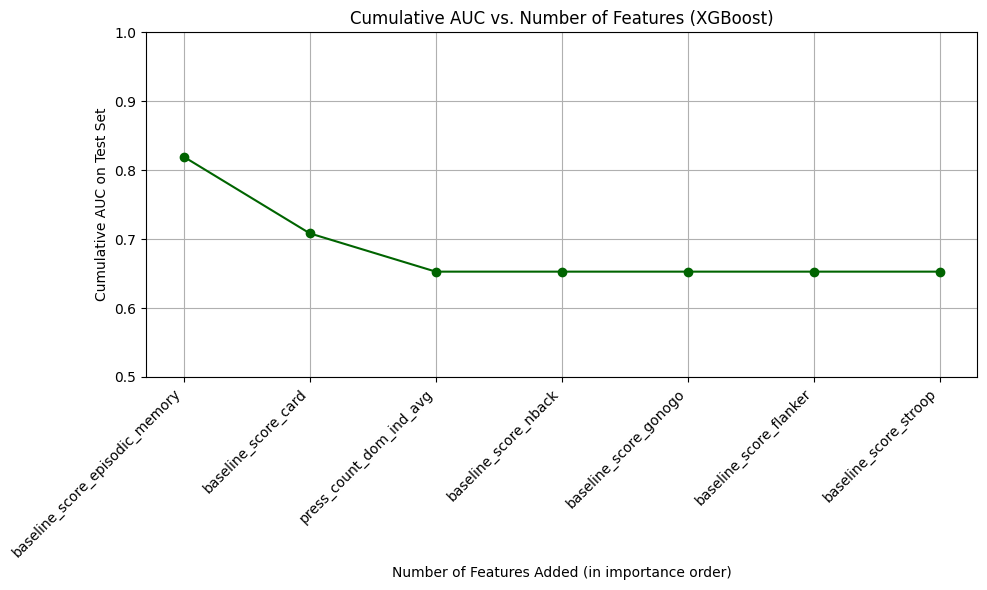

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_auc_score

#Train full model to get feature importances
model = xgb.XGBClassifier(
    n_estimators=125,
    max_depth=2,
    learning_rate=0.005,
    random_state=42
)
model.fit(X_train, y_train)

#Get sorted feature indices by importance
importance = model.feature_importances_
sorted_idx = np.argsort(importance)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

#Track cumulative AUC as features are added
cumulative_auc = []

for i in range(1, len(sorted_features) + 1):
    selected_features = sorted_features[:i]
    selected_idx = [feature_names.index(f) for f in selected_features]

    X_train_selected = X_train[:, selected_idx]
    X_test_selected = X_test[:, selected_idx]

    temp_model = xgb.XGBClassifier(
        n_estimators=125,
        max_depth=2,
        learning_rate=0.005,
        random_state=42
    )
    temp_model.fit(X_train_selected, y_train)
    y_pred_proba = temp_model.predict_proba(X_test_selected)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    cumulative_auc.append(auc)

#Plot cumulative AUC
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_features) + 1), cumulative_auc, marker='o', color='darkgreen')
plt.xticks(ticks=range(1, len(sorted_features) + 1), labels=sorted_features, rotation=45, ha='right')
plt.xlabel('Number of Features Added (in importance order)')
plt.ylabel('Cumulative AUC on Test Set')
plt.title('Cumulative AUC vs. Number of Features (XGBoost)')
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

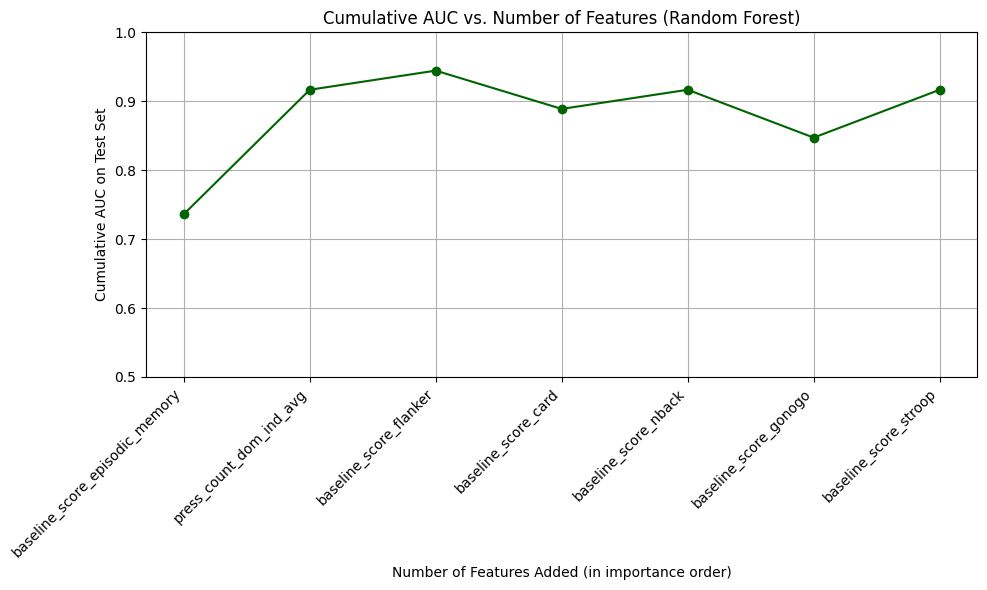

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

#Train full Random Forest model to get feature importances
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    random_state=42
)
rf_model.fit(X_train, y_train)

#Get feature importances and sort them
importance = rf_model.feature_importances_
sorted_idx = np.argsort(importance)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

#Track cumulative AUC as features are added
cumulative_auc = []

for i in range(1, len(sorted_features) + 1):
    selected_features = sorted_features[:i]
    selected_idx = [feature_names.index(f) for f in selected_features]

    X_train_selected = X_train[:, selected_idx]
    X_test_selected = X_test[:, selected_idx]

    temp_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=None,
        random_state=42
    )
    temp_model.fit(X_train_selected, y_train)
    y_pred_proba = temp_model.predict_proba(X_test_selected)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    cumulative_auc.append(auc)

#Plot cumulative AUC
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_features) + 1), cumulative_auc, marker='o', color='darkgreen')
plt.xticks(ticks=range(1, len(sorted_features) + 1), labels=sorted_features, rotation=45, ha='right')
plt.xlabel('Number of Features Added (in importance order)')
plt.ylabel('Cumulative AUC on Test Set')
plt.title('Cumulative AUC vs. Number of Features (Random Forest)')
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()